In [91]:
#!/usr/bin/python
import csv
import time
import json
import talib
import requests
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from datetime import datetime, date, timedelta, timezone
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

In [92]:
headers = {'Content-Type': 'application/json'}
api_url_base = 'https://public.bitbank.cc'
pair = 'btc_jpy'
period = '1min'

today = datetime.today()
yesterday = today - timedelta(days=1)
today = "{0:%Y%m%d}".format(today)
yesterday = "{0:%Y%m%d}".format(yesterday)

In [93]:
def api_ohlcv(timestamp):
    api_url = '{0}/{1}/candlestick/{2}/{3}'.format(api_url_base, pair, period, timestamp)
    response = requests.get(api_url, headers=headers)

    if response.status_code == 200:
        ohlcv = json.loads(response.content.decode('utf-8'))['data']['candlestick'][0]['ohlcv']
        return ohlcv
    else:
        return None

In [94]:
ohlcv = api_ohlcv('20190901')
open, high, low, close, volume, timestamp = [],[],[],[],[],[]
for i in ohlcv:
    open.append(int(i[0]))
    high.append(int(i[1]))
    low.append(int(i[2]))
    close.append(int(i[3]))
    volume.append(float(i[4]))
    time_str = str(i[5])
    timestamp.append(datetime.fromtimestamp(int(time_str[:10])).strftime('%Y/%m/%d %H:%M:%M'))

date_time_index = pd.to_datetime(timestamp) # convert to DateTimeIndex type
df = pd.DataFrame({'open': open, 'high': high, 'low': low, 'close': close, 'volume': volume}, index=date_time_index)
# df.index += pd.offsets.Hour(9) # adjustment for JST
print(df.shape)
print(df.columns)

(1440, 5)
Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')


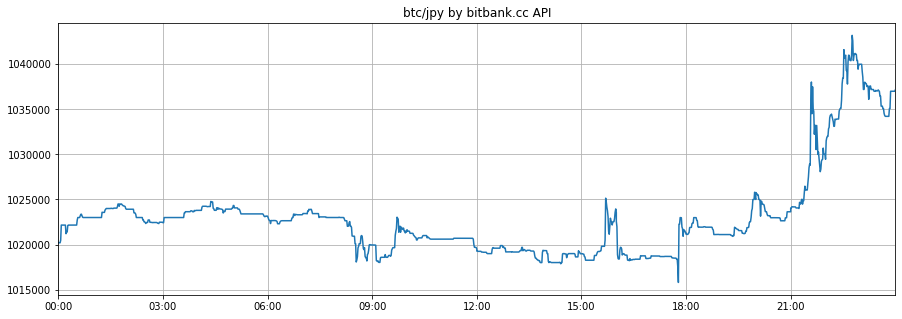

In [95]:
def draw(df):
    df1 = df.copy()
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('btc/jpy by bitbank.cc API')
    ax.plot(df1.index, df1.close,label="original")
    ax.set_xlim(df1.index[0], df1.index[-1])
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
    ax.grid()
    
draw(df)

In [96]:
# pct_change
f = lambda x: 1 if x>0.0001 else -1 if x<-0.0001 else 0 if -0.0001<=x<=0.0001 else np.nan
y = df.rename(columns={'close': 'y'}).loc[:, 'y'].pct_change(1).shift(-1).fillna(0)
X = df.copy()
y_ = pd.DataFrame(y.map(f), columns=['y'])
df_ = pd.concat([X, y_], axis=1)
input_arrays = { 'open': df['open'].values, 'high': df['high'].values, 'low': df['low'].values, 'close': df['close'].values, 'volume': df['volume'].values }

# check the shape
print('----------------------------------------------------------------------------------------')
print('X shape: (%i,%i)' % X.shape)
print('y shape: (%i,%i)' % y_.shape)
print('----------------------------------------------------------------------------------------')
print(y_.groupby('y').size())
print('y=1 up, y=0 stay, y=-1 down')
print('----------------------------------------------------------------------------------------')
pd.set_option('display.max_rows', 200)

----------------------------------------------------------------------------------------
X shape: (1440,5)
y shape: (1440,1)
----------------------------------------------------------------------------------------
y
-1     172
 0    1092
 1     176
dtype: int64
y=1 up, y=0 stay, y=-1 down
----------------------------------------------------------------------------------------


In [97]:
# feature calculation
open = pd.Series(df['open'])
high = pd.Series(df['high'])
low = pd.Series(df['low'])
close = pd.Series(df['close'])
volume = pd.Series(df['volume'])

# pct_change for new column
X['diff'] = y

# Exponential Moving Average
ema = talib.EMA(close, timeperiod=3)
ema = ema.fillna(ema.mean())

# Momentum
momentum = talib.MOM(close, timeperiod=5)
momentum = momentum.fillna(momentam.mean())

# RSI
rsi = talib.RSI(close, timeperiod=14)
rsi = rsi.fillna(rsi.mean())

# ADX
adx = talib.ADX(high, low, close, timeperiod=14)
adx = adx.fillna(adx.mean())

# ADX change
adx_change = adx.pct_change(1).shift(-1)
adx_change = adx_change.fillna(adx_change.mean())

# AD
ad = talib.AD(high, low, close, volume)
ad = ad.fillna(ad.mean())

X_ = pd.concat([X, ema, momentum, rsi, adx_change, ad], axis=1).drop(['open', 'high', 'low', 'close'], axis=1)
X_.columns = ['volume','diff', 'ema', 'momentum', 'rsi', 'adx', 'ad']
X_.join(y_).head(200)

,volume,diff,ema,momentum,rsi,adx,ad,y
2019-09-01 00:00:00,0.0001,0.000000e+00,1.023021e+06,58.44669,50.137436,0.000000,0.000000,0
2019-09-01 00:01:01,0.0000,0.000000e+00,1.023021e+06,58.44669,50.137436,0.000000,0.000000,0
2019-09-01 00:02:02,0.0000,0.000000e+00,1.020201e+06,58.44669,50.137436,0.000000,0.000000,0
2019-09-01 00:03:03,0.0004,2.715151e-04,1.020201e+06,58.44669,50.137436,0.000000,0.000000,1
2019-09-01 00:04:04,1.0640,1.650207e-03,1.020340e+06,58.44669,50.137436,0.000000,1.064000,1
2019-09-01 00:05:05,1.5353,9.783185e-07,1.021251e+06,1961.00000,50.137436,0.000000,2.599300,0
2019-09-01 00:06:06,0.0101,0.000000e+00,1.021707e+06,1962.00000,50.137436,0.000000,2.609400,0
2019-09-01 00:07:07,0.0001,-9.783175e-07,1.021935e+06,1962.00000,50.137436,0.000000,2.609400,0
2019-09-01 00:08:08,0.3106,9.783185e-07,1.022048e+06,1961.00000,50.137436,0.000000,2.609400,0
2019-09-01 00:09:09,0.2599,0.000000e+00,1.022106e+06,1685.00000,50.137436,0.000000,2.869300,0


volume      float64
diff        float64
ema         float64
momentum    float64
rsi         float64
adx         float64
ad          float64
y             int64
dtype: object
 0    1092
 1     176
-1     172
Name: y, dtype: int64


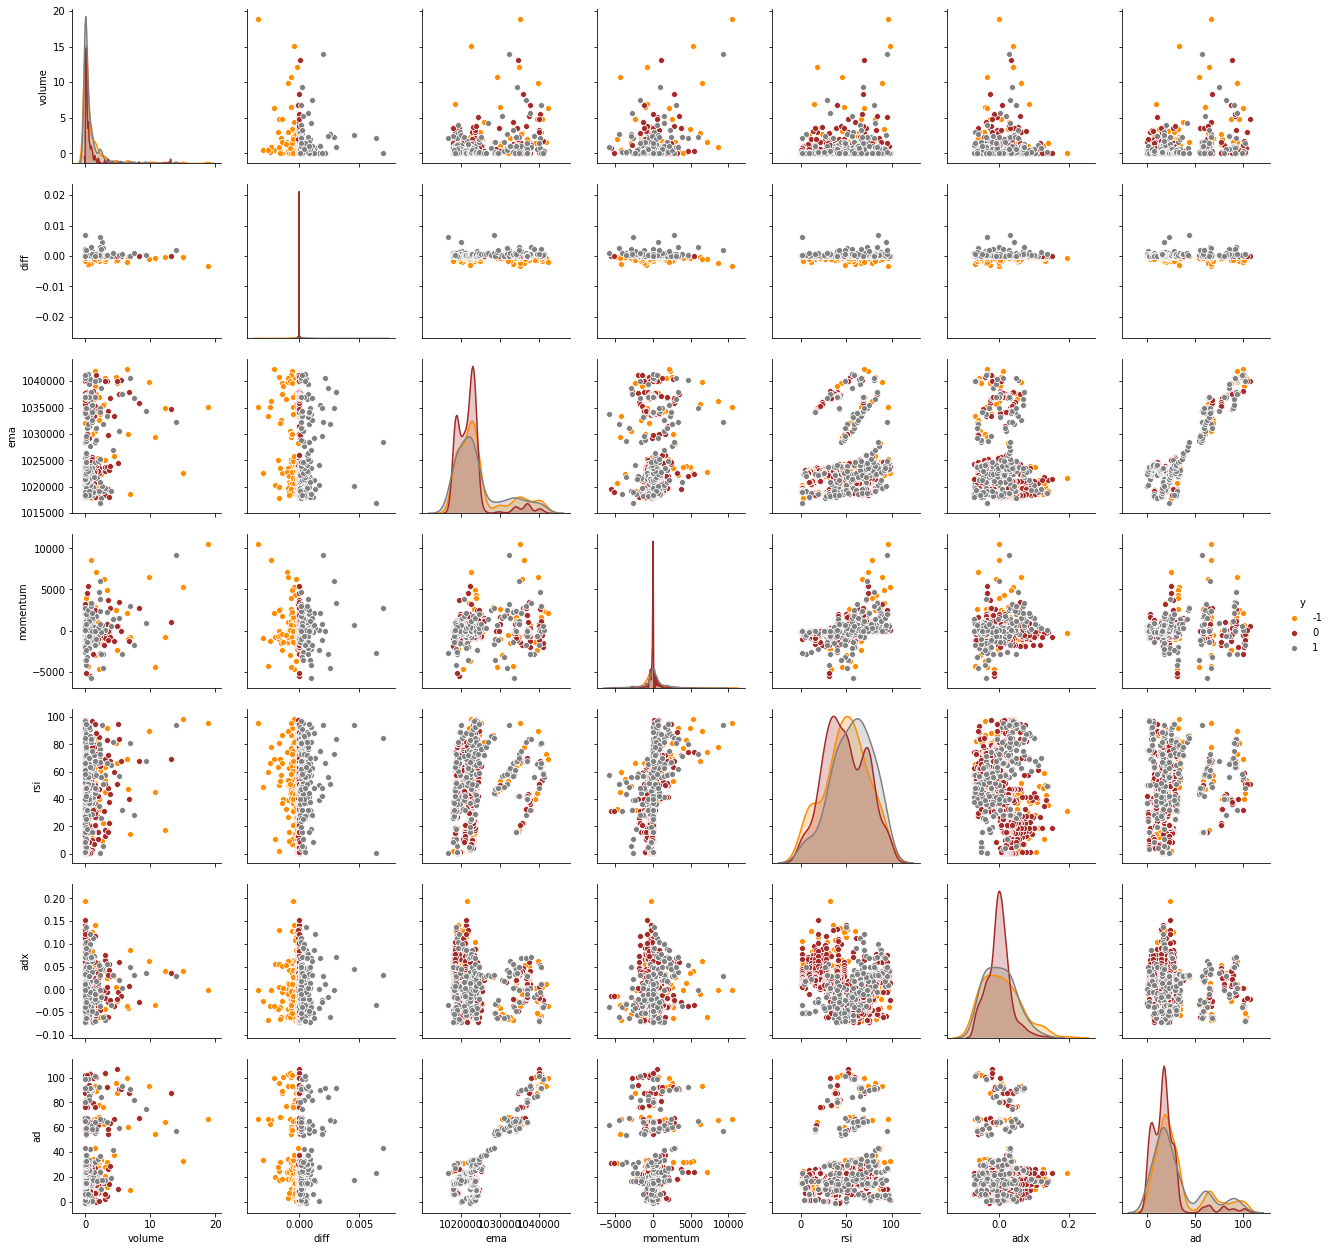

In [99]:
# seaborn plot
import seaborn as sns
df_ml = X_.join(y_)
print(df_ml.dtypes)
print(df_ml['y'].value_counts())
sns.pairplot(df_ml, hue='y', vars=['volume', 'diff', 'ema', 'momentum', 'rsi', 'adx', 'ad'], palette={1: 'gray', 0: 'brown', -1: 'darkorange'})

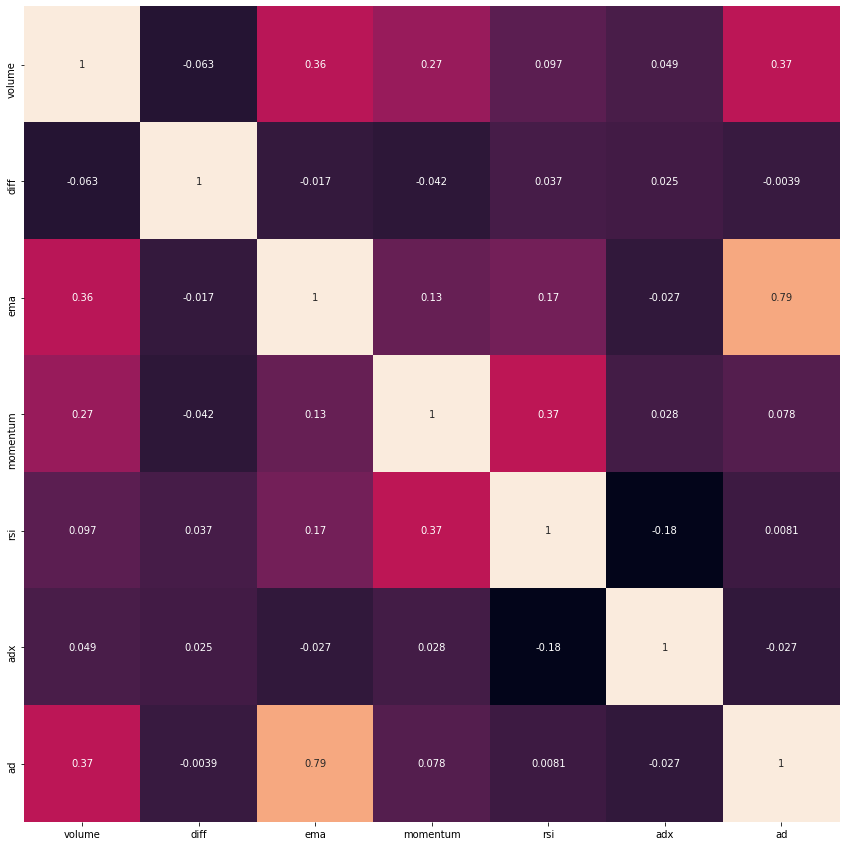

In [100]:
# heatmap plot
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1)
sns.heatmap(X_.astype(float).corr(), vmax=1.0, square=True, linecolor='white', annot=True, ax=ax, cbar=False)

In [101]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.33, random_state=42)
print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_train shape: {}'.format(y_train.shape))
print('y_test shape: {}'.format(y_test.shape))

pipe_knn = Pipeline([('scl', StandardScaler()), ('est', KNeighborsClassifier(n_neighbors=3))])
pipe_logistic = Pipeline([('scl', StandardScaler()), ('est', LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=39))])
pipe_rf = Pipeline([('scl', StandardScaler()), ('est', RandomForestClassifier(random_state=39))])
pipe_gb = Pipeline([('scl', StandardScaler()), ('est', GradientBoostingClassifier(random_state=39))])

pipe_names = ['KNN','Logistic','RandomForest','GradientBoosting']
pipe_lines = [pipe_knn, pipe_logistic, pipe_rf, pipe_gb]

for (i, pipe) in enumerate(pipe_lines):
    pipe.fit(X_train, y_train.values.ravel())
    print('%s: %.3f' % (pipe_names[i] + ' Train Accuracy', accuracy_score(y_train.values.ravel(), pipe.predict(X_train))))
    print('%s: %.3f' % (pipe_names[i] + ' Test Accuracy', accuracy_score(y_test.values.ravel(), pipe.predict(X_test))))
    print('%s: %.3f' % (pipe_names[i] + ' Train F1 Score', f1_score(y_train.values.ravel(), pipe.predict(X_train), average='micro')))
    print('%s: %.3f' % (pipe_names[i] + ' Test F1 Score', f1_score(y_test.values.ravel(), pipe.predict(X_test), average='micro')))

X_train shape: (964, 7)
X_test shape: (476, 7)
y_train shape: (964, 1)
y_test shape: (476, 1)
KNN Train Accuracy: 0.922
KNN Test Accuracy: 0.859
KNN Train F1 Score: 0.922
KNN Test F1 Score: 0.859
Logistic Train Accuracy: 0.951
Logistic Test Accuracy: 0.947
Logistic Train F1 Score: 0.951
Logistic Test F1 Score: 0.947
RandomForest Train Accuracy: 1.000
RandomForest Test Accuracy: 0.998
RandomForest Train F1 Score: 1.000
RandomForest Test F1 Score: 0.998


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GradientBoosting Train Accuracy: 1.000
GradientBoosting Test Accuracy: 1.000
GradientBoosting Train F1 Score: 1.000
GradientBoosting Test F1 Score: 1.000


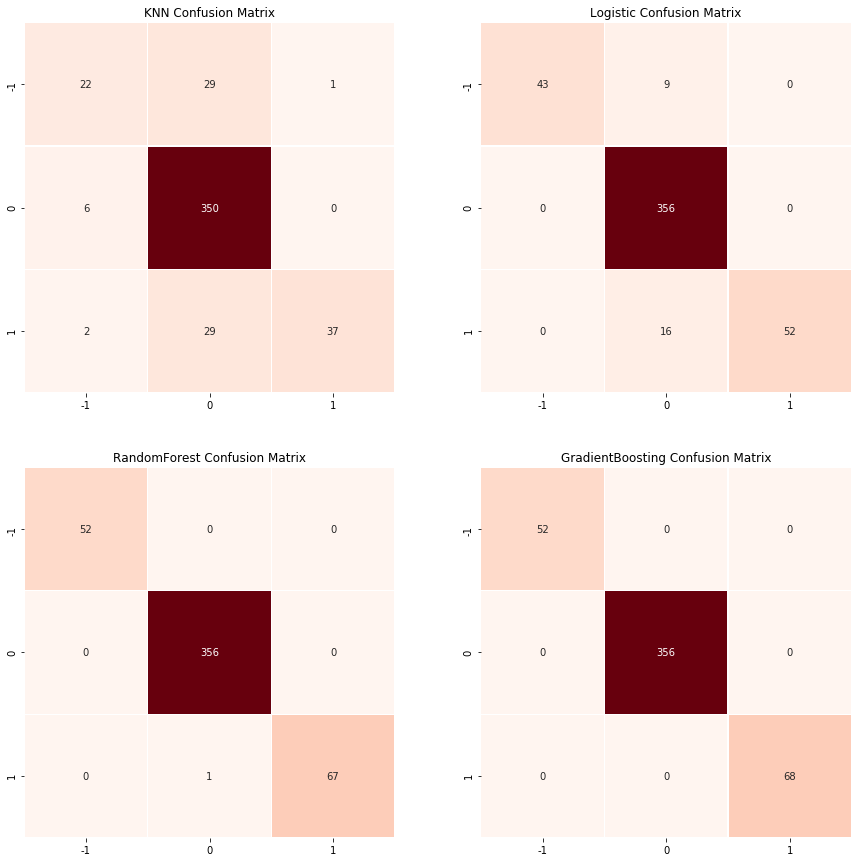

In [102]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
fig = plt.figure(figsize=(15, 15))

for (i, pipe) in enumerate(pipe_lines):
    predict = pipe.predict(X_test)
    cm = confusion_matrix(y_test.values.ravel(), predict, labels=[-1, 0, 1])
    ax = fig.add_subplot(2, 2, i+1)
    ax.set_title(pipe_names[i] + ' Confusion Matrix')
    sns.heatmap(cm, square=True, linecolor='white', annot=True, ax=ax, cmap="Reds", cbar=False, fmt='d', linewidths=.5, xticklabels=[-1,0,1], yticklabels=[-1,0,1])

X_train shape: (964, 7)
X_test shape: (476, 7)
y_train shape: (964, 3)
y_test shape: (476, 3)


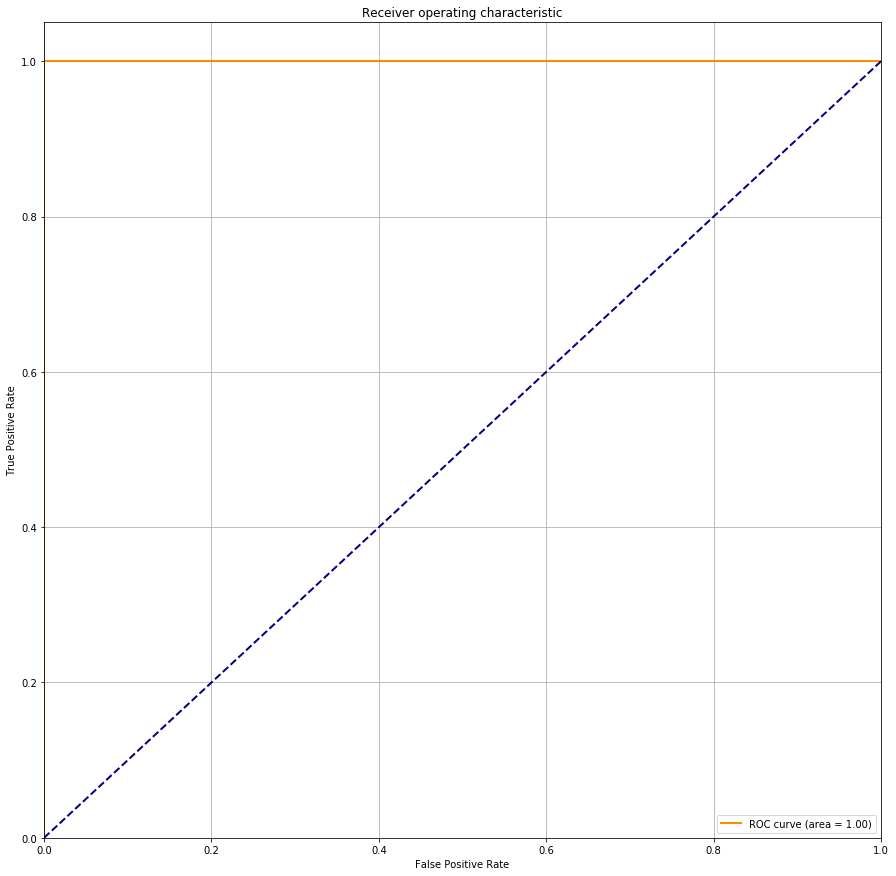

In [77]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize the output
y_binarized = label_binarize(y_, classes=[-1, 0, 1])
n_classes = y_binarized.shape[1]

X_train_binarized, X_test_binarized, y_train_binarized, y_test_binarized = train_test_split(X_, y_binarized, test_size=0.33, random_state=42)
print('X_train shape: {}'.format(X_train_binarized.shape))
print('X_test shape: {}'.format(X_test_binarized.shape))
print('y_train shape: {}'.format(y_train_binarized.shape))
print('y_test shape: {}'.format(y_test_binarized.shape))

# Learn to predict each class against the other
pipe_binarized = Pipeline([('scl', StandardScaler()), ('est', GradientBoostingClassifier(random_state=39))])
ovr_clf = OneVsRestClassifier(pipe_binarized) 
y_score_binarized = ovr_clf.fit(X_train_binarized, y_train_binarized).decision_function(X_test_binarized)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score_binarized.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# plot ROC curve
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1)
lw = 2
ax.plot(fpr[2], tpr[2], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
ax.legend(loc="lower right")
ax.grid()

In [89]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
cv = cross_val_score(pipe_gb, X_, y_.values.ravel(), cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=39))
print('Cross Validation with StratifiedKFold mean: {}'.format(cv.mean()))

Cross Validation with StratifiedKFold mean: 0.9993055555555556


In [78]:
df_ = df.copy()
df_.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
print('df_ shape: {}'.format(df_.shape))
print(df_.columns)

df_ shape: (1440, 5)
Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [79]:
from backtesting import Strategy

def GB_Backtesting(df):
    """
    Return the label from calculating df(close, volume, diff1, diff2), at
    each step taking into account `n` previous values.
    """
    return pipe_gb.predict(df)

class MachineLearning(Strategy):
    
    def init(self):
        # Precompute a label for data
        open = pd.DataFrame({'Open': self.data.Open})
        high = pd.DataFrame({'High': self.data.High})
        low = pd.DataFrame({'Low': self.data.Low})
        close = pd.DataFrame({'Close': self.data.Close})
        volume = pd.DataFrame({'Volume': self.data.Volume})
        ohlcv = open.join(high).join(low).join(close).join(volume)

        # Calculate pct_change for Close
        diff = ohlcv.rename(columns={'Close': 'diff'}).loc[:, 'diff'].pct_change(1).shift(-1).fillna(0)

        open2 = pd.Series(self.data.Open)
        high2 = pd.Series(self.data.High)
        low2 = pd.Series(self.data.Low)
        close2 = pd.Series(self.data.Close)
        volume2 = pd.Series(self.data.Volume)

        # Exponential Moving Average
        ema = talib.EMA(close2, timeperiod=3)
        ema = ema.fillna(ema.mean())

        # Momentum
        momentam = talib.MOM(close2, timeperiod=5)
        momentam = momentam.fillna(momentam.mean())

        # RSI
        rsi = talib.RSI(close2, timeperiod=14)
        rsi = rsi.fillna(rsi.mean())

        # ADX
        adx = talib.ADX(high2, low2, close2, timeperiod=14)
        adx = adx.fillna(adx.mean())

        # ADX change
        adx_change = adx.pct_change(1).shift(-1)
        adx_change = adx_change.fillna(adx_change.mean())

        # AD
        ad = talib.AD(high2, low2, close2, volume2)
        ad = ad.fillna(ad.mean())

        X_ = pd.concat([ohlcv, diff, ema, momentam, rsi, adx_change, ad], axis=1).drop(['Open', 'High', 'Low', 'Close'], axis=1)
        X_.columns = ['volume', 'diff', 'ema', 'momentam', 'rsi', 'adx', 'ad']
        self.df = X_
        self.label = self.I(GB_Backtesting, self.df)
    
    def next(self):
        if self.label == 1:
            self.buy()
        elif self.label == -1:
            self.sell()

In [41]:
from backtesting import Backtest

bt = Backtest(df_, MachineLearning, cash=1, commission=.002)
bt.run()

Start                     2019-09-01 00:00:00
End                       2019-09-01 23:59:59
Duration                      0 days 23:59:59
Exposure [%]                          99.7176
Equity Final [$]                     0.585944
Equity Peak [$]                             1
Return [%]                           -41.4056
Buy & Hold Return [%]                 1.66134
Max. Drawdown [%]                    -41.4056
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                  347
Win Rate [%]                          2.30548
Best Trade [%]                       0.496081
Worst Trade [%]                     -0.277969
Avg. Trade [%]                      -0.153652
Max. Trade Duration           0 days 01:19:19
Avg. Trade Duration           0 days 00:04:09
Expectancy [%]                       0.162569
SQN                                  -37.0528
Sharpe Ratio                      